# Labeling

For each ticker, we want to label the best buy/sell/hold actions (this is the classification label we will train on).

This is the starting logic (before extra cases complicate it):

- iterate over prices for the ticker (over time)
- e.g. prices: 
- for the first record, we will buy 1 share at that price (this becomes our balance)
- for every following record:
    - if the current price is more than the previous price
        - action = "sell"
        - if previous action is "sell", set previous row action to "hold"
    - if the current price is less than the previous price
        - action = "buy"
        - if previous action is "buy", set previous row action to "hold"
    - keep track of cost basis and profit/loss based on current liquid and realized values

This will iterate like so over the following price list:

- prices = [20, 21, 22, 18, 17, 16, 17]
- actions = 
- buy
- buy, sell
- buy, hold, sell
- buy, hold, sell, buy
- buy, hold, sell, hold, buy
- buy, hold, sell, hold, hold, buy
- buy, hold, sell, hold, hold, buy, sell (final action list)
- $3 profit

In [440]:
import pandas as pd
import os
import matplotlib.pylab as plt
import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)
# logging.getLogger('foo').debug('bah')
# logging.getLogger().setLevel(logging.DEBUG)
# logging.getLogger('foo').debug('bah')

In [441]:
df = pd.read_csv('signals.csv',index_col=None, header=None)
df.columns = ["ticker","price","change","time","meta_signal","meta_previous",
                "4h","1d","1w","1m",
                "4hp","1dp","1wp","1mp",
                "4h_rsi","4h_stochrsi","4h_stoch","4h_ult","4h_macd","4h_hull",
                "1d_rsi","1d_stochrsi","1d_stoch","1d_ult","1d_macd","1d_hull",
                "1w_rsi","1w_stochrsi","1w_stoch","1w_ult","1w_macd","1w_hull",
                "1m_rsi","1m_stochrsi","1m_stoch","1m_ult","1m_macd","1m_hull"
                ,"market","name","meta_move"
                ]
df.head(5)

,ticker,price,change,time,meta_signal,meta_previous,4h,1d,1w,1m,...,1w_hull,1m_rsi,1m_stochrsi,1m_stoch,1m_ult,1m_macd,1m_hull,market,name,meta_move
0,NASDAQ-AAPL,215.05,0.0000,1534986919851,1,2,1,1,1,1,...,88.93,62.55,1.0,-1,-1,-1,1.0,NASDAQ,AAPL,-1
1,NASDAQ-AAPL,215.97,0.0043,1535031826650,1,2,1,1,1,1,...,89.25,62.95,1.0,1,-1,-1,1.0,NASDAQ,AAPL,-1
2,NASDAQ-AAPL,216.11,0.0006,1535035652301,1,2,1,1,1,1,...,89.33,63.06,1.0,1,-1,-1,1.0,NASDAQ,AAPL,-1
3,NASDAQ-AAPL,215.37,-0.0034,1535039080621,1,2,1,1,1,1,...,89.01,62.66,1.0,1,-1,-1,1.0,NASDAQ,AAPL,-1
4,NASDAQ-AAPL,216.27,0.0042,1535042375489,1,2,1,1,1,1,...,89.39,63.13,1.0,1,-1,-1,1.0,NASDAQ,AAPL,-1


In [442]:
def label_actions(df_ticker, ticker, verbose=False):
    df_ticker['action'] = 'hold'
    holding=0
    cost_basis=0
    liquid=0
    profit=0
    buys=0
    sells=0
    last_basis=0
    last_row_i=-1
    last_quantity_sold=0
    last_profit=0
    first_row_i=0
    for i, row in df_ticker.iterrows():
        if last_row_i==-1:
            # first record: buy one
            buys=1
            holding=1
            cost_basis = row.price
            df_ticker.set_value(i,'action','buy')
            first_row_i = i
        else:
            last_row = df_ticker.loc[last_row_i]
            last_sell = last_row.action=='sell'
            last_buy = last_row.action=='buy'
            price_same = row.price == last_row.price
            # >= to catch moving the sell signal over a plateau 
            if (row.price >= cost_basis) & ((row.price > last_row.price) | (price_same & last_sell)):
                df_ticker.set_value(i,'action','sell')
                if last_row.action == "sell":
                    if verbose:
                        print("push signal")
                    df_ticker.set_value(last_row_i,'action','hold')
                    # remove the recorded profit from the last sale
                    profit -= last_profit
                    # add the profit from selling at this price
                    last_profit=(last_quantity_sold * (row.price - last_basis))
                    profit += last_profit
                else:
                    if holding == 0:
                       print('!!!!!!!!!!!!Anomaly!!', ticker) 
                    last_quantity_sold=holding
                    last_profit=(holding * (row.price - cost_basis))
                    profit += last_profit
                    sells += 1
                    last_basis=cost_basis
                holding = 0
                cost_basis = 0
            elif ((cost_basis==0) | (row.price <= cost_basis)) & ((row.price < last_row.price) | (price_same & last_buy)):
                df_ticker.set_value(i,'action','buy')
                if (last_row.action == "buy"):
                    if verbose:
                        print("push signal")
                    df_ticker.set_value(last_row_i,'action','hold')
                    # adjust the recorded cost-basis to the new cost
                    last_held = holding-1
                    if last_held==0:
                        cost_basis = row.price
                    else:
                        cost_basis = ((last_basis * last_held) + row.price) / (holding)
                    last_basis=cost_basis
                else:
                    last_basis = cost_basis
                    if holding==0:
                        cost_basis = row.price
                    else:
                        cost_basis = ((cost_basis * holding) + row.price) / (holding+1)
                    holding += 1
                    buys += 1
                    
        if verbose:
            print(df_ticker.get_value(i,'action'), "\tprice: {0:.4f}".format(row.price), '\tholding:', holding, "\tbasis: {0:.4f}".format(cost_basis),"\tlast basis: {0:.4f}".format(last_basis), "\tprofit: {0:.4f}".format(profit))

        last_row_i = i
        liquid = (row.price*holding) - (cost_basis*holding) + profit

    print(ticker+'\t', "holding:", holding, "\tbasis:", "{0:.2f}".format(cost_basis), "\trealized:", "{0:.2f}".format(profit), "\tliquid:","{0:.2f}".format(liquid), "\tbuys:", buys, "\tsells:",sells)
    return df_ticker

In [443]:
ticker_groups = df.groupby('ticker')

buy 	price: 19.0600 	holding: 1 	basis: 19.0600 	last basis: 0.0000 	profit: 0.0000
push signal
buy 	price: 18.6900 	holding: 1 	basis: 18.6900 	last basis: 18.6900 	profit: 0.0000
push signal
buy 	price: 18.5400 	holding: 1 	basis: 18.5400 	last basis: 18.5400 	profit: 0.0000
push signal
buy 	price: 18.5400 	holding: 1 	basis: 18.5400 	last basis: 18.5400 	profit: 0.0000
push signal
buy 	price: 18.5000 	holding: 1 	basis: 18.5000 	last basis: 18.5000 	profit: 0.0000
push signal
buy 	price: 18.4400 	holding: 1 	basis: 18.4400 	last basis: 18.4400 	profit: 0.0000
push signal
buy 	price: 18.4200 	holding: 1 	basis: 18.4200 	last basis: 18.4200 	profit: 0.0000
push signal
buy 	price: 18.3950 	holding: 1 	basis: 18.3950 	last basis: 18.3950 	profit: 0.0000
sell 	price: 18.4600 	holding: 0 	basis: 0.0000 	last basis: 18.3950 	profit: 0.0650
push signal
sell 	price: 18.4600 	holding: 0 	basis: 0.0000 	last basis: 18.3950 	profit: 0.0650
push signal
sell 	price: 18.7800 	holding: 0 	basis: 0.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


<IPython.core.display.Javascript object>


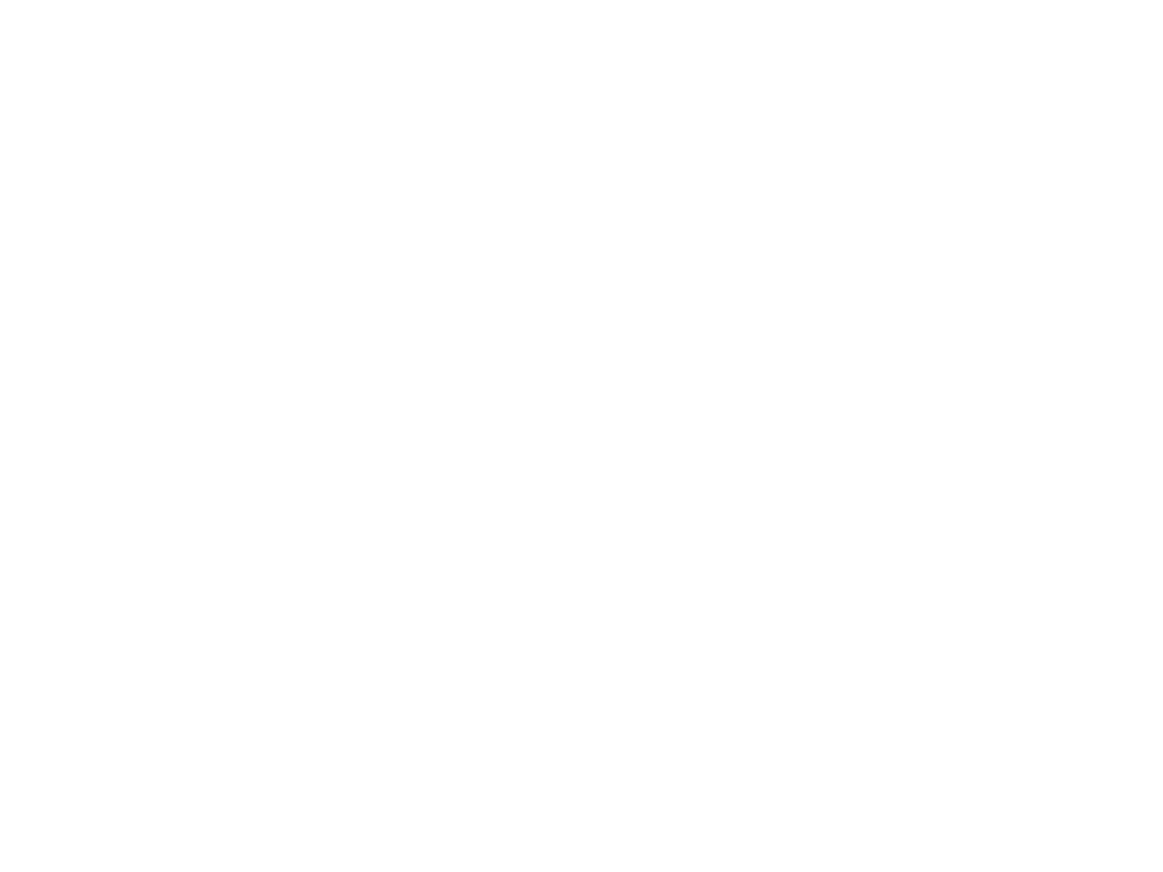

In [444]:
# testing
# test_ticker = 'AMEX-BTG'
# test_ticker = 'AMEX-FXI'
test_ticker = 'AMEX-GDX'
# test_ticker = 'NASDAQ-AAPL'
# test_ticker = 'AMEX-UAMY'
df_test_ticker = label_actions(ticker_groups.get_group(test_ticker), test_ticker, verbose=True)

%matplotlib notebook

plt.figure(1)
plt.title(test_ticker+' signals')
plt.xlabel('Log')
plt.ylabel('Price')
plt.plot(df_test_ticker.price)
plt.plot(df_test_ticker[df_test_ticker.action=="sell"].price, 'ro', label='sell')
plt.plot(df_test_ticker[df_test_ticker.action=="buy"].price, 'go', label='buy')
plt.grid(True)
plt.show()

In [445]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [446]:
df_labeled = pd.DataFrame()
list_ = []

for ticker, group in ticker_groups:
    df_ticker = label_actions(group, ticker)
    list_.append(df_ticker)

df_labeled = pd.concat(list_)
# frame.sort_values(['ticker', 'time'], inplace=True)
df_labeled.head(5)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


AMEX-BTG	 holding: 1 	basis: 2.33 	realized: 0.18 	liquid: 0.18 	buys: 4 	sells: 3
AMEX-COPX	 holding: 1 	basis: 21.55 	realized: 0.61 	liquid: 0.61 	buys: 5 	sells: 4
AMEX-DGRO	 holding: 0 	basis: 0.00 	realized: 0.24 	liquid: 0.24 	buys: 4 	sells: 4
AMEX-EWA	 holding: 0 	basis: 0.00 	realized: 0.33 	liquid: 0.33 	buys: 3 	sells: 3
AMEX-FXI	 holding: 1 	basis: 42.60 	realized: 0.88 	liquid: 0.88 	buys: 5 	sells: 4
AMEX-GDX	 holding: 0 	basis: 0.00 	realized: 0.77 	liquid: 0.77 	buys: 2 	sells: 2
AMEX-GDXJ	 holding: 0 	basis: 0.00 	realized: 1.50 	liquid: 1.50 	buys: 4 	sells: 4
AMEX-GSAT	 holding: 1 	basis: 0.52 	realized: 0.04 	liquid: 0.04 	buys: 5 	sells: 4
AMEX-GTE	 holding: 0 	basis: 0.00 	realized: 0.12 	liquid: 0.12 	buys: 4 	sells: 4
AMEX-HDV	 holding: 0 	basis: 0.00 	realized: 0.53 	liquid: 0.53 	buys: 2 	sells: 2
AMEX-IAU	 holding: 1 	basis: 11.56 	realized: 0.21 	liquid: 0.21 	buys: 2 	sells: 1
AMEX-IDV	 holding: 0 	basis: 0.00 	realized: 0.25 	liquid: 0.25 	buys: 3 	sells:

NYSE-ETN	 holding: 0 	basis: 0.00 	realized: 1.46 	liquid: 1.46 	buys: 4 	sells: 4
NYSE-EXG	 holding: 1 	basis: 9.57 	realized: 0.08 	liquid: 0.08 	buys: 3 	sells: 2
NYSE-EXK	 holding: 1 	basis: 2.33 	realized: 0.20 	liquid: 0.20 	buys: 3 	sells: 2
NYSE-F	 holding: 0 	basis: 0.00 	realized: 0.11 	liquid: 0.11 	buys: 4 	sells: 4
NYSE-FNF	 holding: 1 	basis: 40.63 	realized: 0.67 	liquid: 0.67 	buys: 6 	sells: 5
NYSE-FTV	 holding: 1 	basis: 80.13 	realized: 0.51 	liquid: 0.51 	buys: 7 	sells: 6
NYSE-GE	 holding: 1 	basis: 12.50 	realized: 0.18 	liquid: 0.18 	buys: 6 	sells: 5
NYSE-GG	 holding: 0 	basis: 0.00 	realized: 0.57 	liquid: 0.57 	buys: 4 	sells: 4
NYSE-GGP	 holding: 1 	basis: 21.93 	realized: 0.54 	liquid: 0.54 	buys: 6 	sells: 5
NYSE-GME	 holding: 1 	basis: 16.55 	realized: 0.80 	liquid: 0.80 	buys: 7 	sells: 6
NYSE-HASI	 holding: 1 	basis: 21.14 	realized: 0.23 	liquid: 0.23 	buys: 4 	sells: 3
NYSE-HBM	 holding: 0 	basis: 0.00 	realized: 0.37 	liquid: 0.37 	buys: 3 	sells: 3
N

,ticker,price,change,time,meta_signal,meta_previous,4h,1d,1w,1m,...,1m_rsi,1m_stochrsi,1m_stoch,1m_ult,1m_macd,1m_hull,market,name,meta_move,action
323,AMEX-BTG,2.310,0.0000,1534976694686,-1,0,-1,-1,-1,-1,...,45.06,-1.0,-1,1,1,-1.0,AMEX,BTG,-1,hold
324,AMEX-BTG,2.240,-0.0303,1535032150741,-1,0,-1,-1,-1,-1,...,43.23,-1.0,-1,-1,-1,-1.0,AMEX,BTG,-1,hold
325,AMEX-BTG,2.235,-0.0022,1535036020573,-1,0,-1,-1,-1,-1,...,42.94,-1.0,-1,-1,-1,-1.0,AMEX,BTG,-1,hold
326,AMEX-BTG,2.210,-0.0112,1535039443967,-1,0,-1,-1,-1,-1,...,42.24,-1.0,-1,-1,-1,-1.0,AMEX,BTG,-1,buy
327,AMEX-BTG,2.215,0.0023,1535042714300,-1,0,-1,-1,-1,-1,...,42.24,-1.0,-1,-1,-1,-1.0,AMEX,BTG,-1,hold


In [447]:
# testing
test_ticker = 'AMEX-GDX'
# test_ticker = 'AMEX-UAMY'
df_test_ticker = df_labeled[df_labeled.ticker == test_ticker]
df_test_ticker

,ticker,price,change,time,meta_signal,meta_previous,4h,1d,1w,1m,...,1m_rsi,1m_stochrsi,1m_stoch,1m_ult,1m_macd,1m_hull,market,name,meta_move,action
1021,AMEX-GDX,19.060,0.0000,1534983146605,-1,-1,-1,-1,-1,-1,...,36.32,-1.0,-1,1,1,-1.0,AMEX,GDX,0,hold
1022,AMEX-GDX,18.690,-0.0194,1535032865934,-1,-1,-1,-1,-2,-1,...,34.24,-1.0,-1,-1,-1,-1.0,AMEX,GDX,0,hold
1023,AMEX-GDX,18.540,-0.0080,1535036788243,-1,-1,-1,-1,-1,-1,...,33.40,-1.0,-1,-1,-1,-1.0,AMEX,GDX,0,hold
1024,AMEX-GDX,18.540,0.0000,1535040190343,-1,-1,-1,-1,-1,-1,...,33.40,-1.0,-1,-1,-1,-1.0,AMEX,GDX,0,hold
1025,AMEX-GDX,18.500,-0.0022,1535043439500,-1,-1,-1,-1,-1,-1,...,33.20,-1.0,-1,-1,-1,-1.0,AMEX,GDX,0,hold
1026,AMEX-GDX,18.440,-0.0032,1535046672412,-1,-1,-1,-1,-1,-1,...,32.84,-1.0,-1,-1,-1,-1.0,AMEX,GDX,0,hold
1027,AMEX-GDX,18.420,-0.0011,1535049929542,-1,-1,-1,-1,-1,-1,...,32.75,-1.0,-1,-1,-1,-1.0,AMEX,GDX,0,hold
1028,AMEX-GDX,18.395,-0.0014,1535053159710,-1,-1,-1,-1,-1,-1,...,32.56,-1.0,-1,-1,-1,-1.0,AMEX,GDX,0,buy
1029,AMEX-GDX,18.460,0.0035,1535056349986,-1,-1,-1,-1,-1,-1,...,32.95,-1.0,-1,-1,-1,-1.0,AMEX,GDX,0,hold
1030,AMEX-GDX,18.460,0.0000,1535059551958,-1,-1,-1,-1,-1,-1,...,32.95,-1.0,-1,-1,-1,-1.0,AMEX,GDX,0,hold


<IPython.core.display.Javascript object>


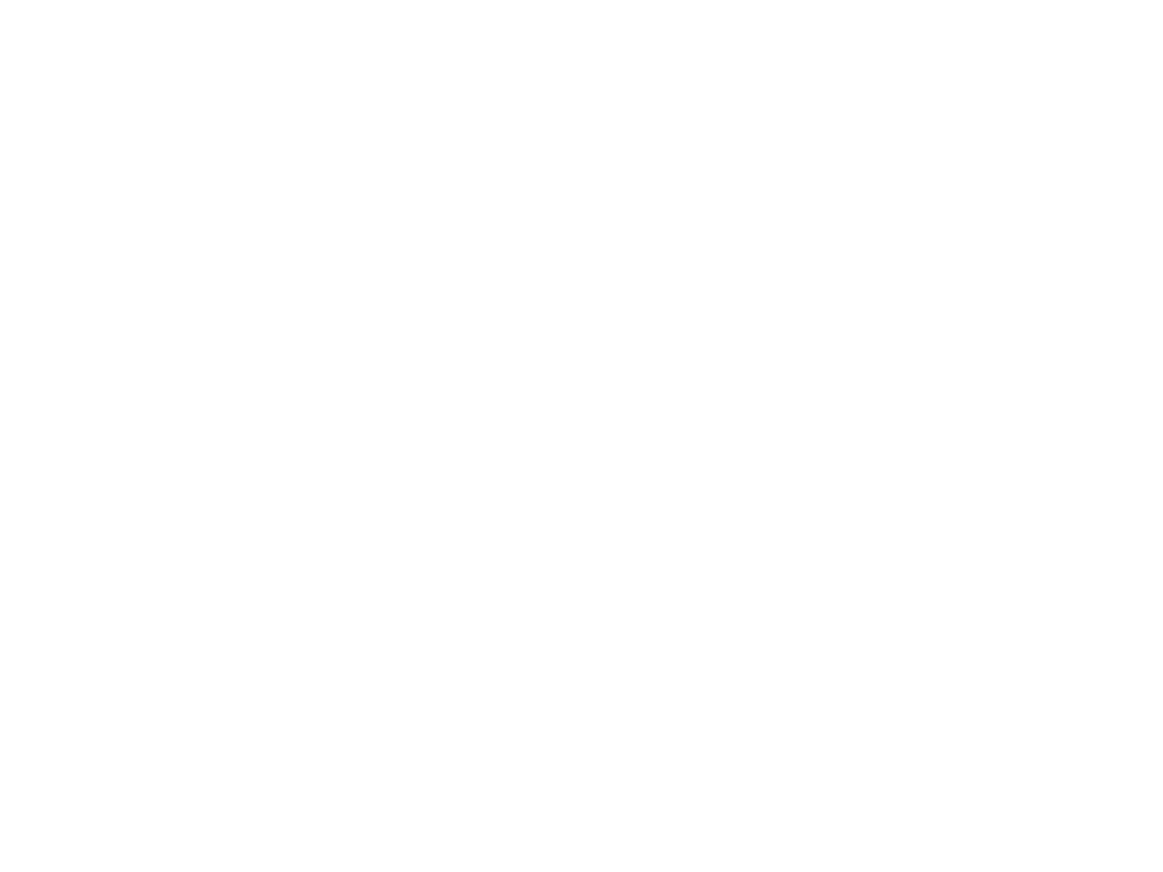

In [448]:


%matplotlib notebook

plt.figure(1)
plt.title(test_ticker+' signals')
plt.xlabel('Log')
plt.ylabel('Price')
plt.plot(df_test_ticker.price)
plt.plot(df_test_ticker[df_test_ticker.action=="sell"].price, 'ro', label='sell')
plt.plot(df_test_ticker[df_test_ticker.action=="buy"].price, 'go', label='buy')
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>


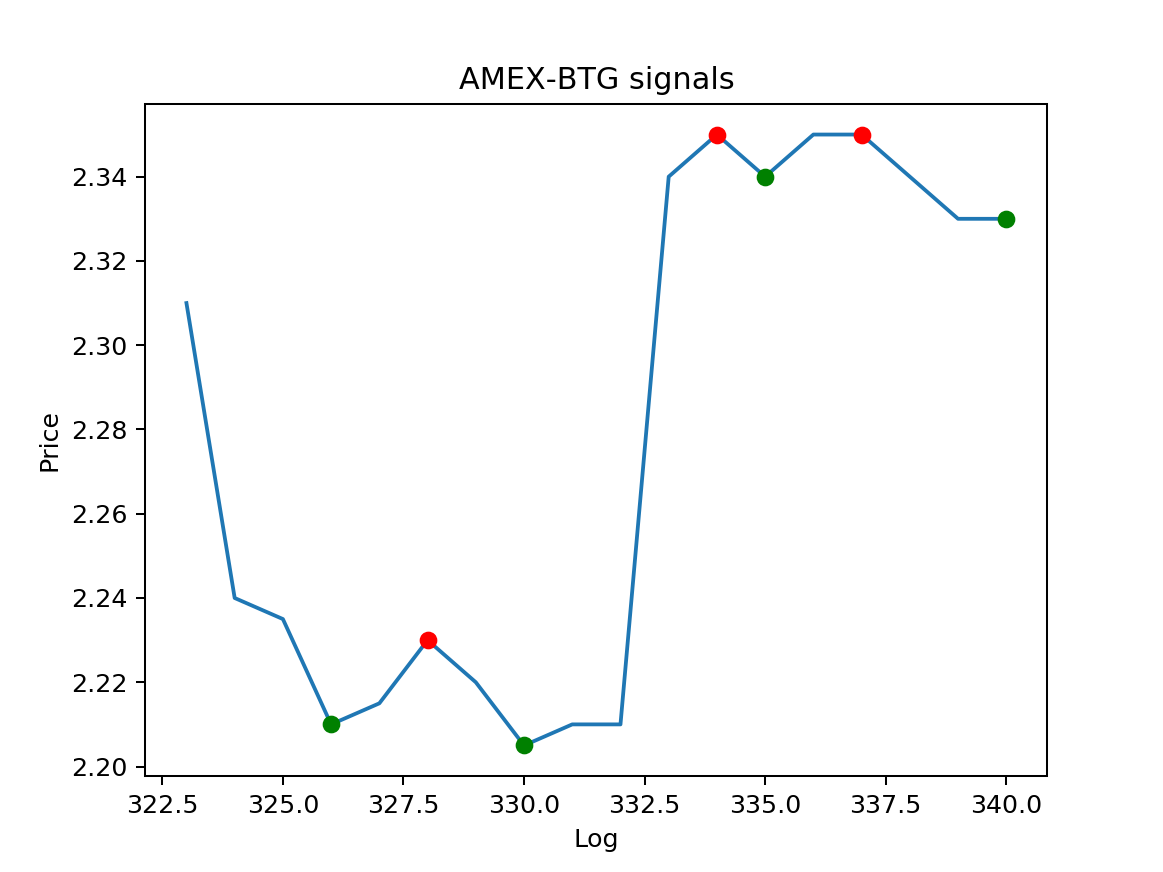

<IPython.core.display.Javascript object>


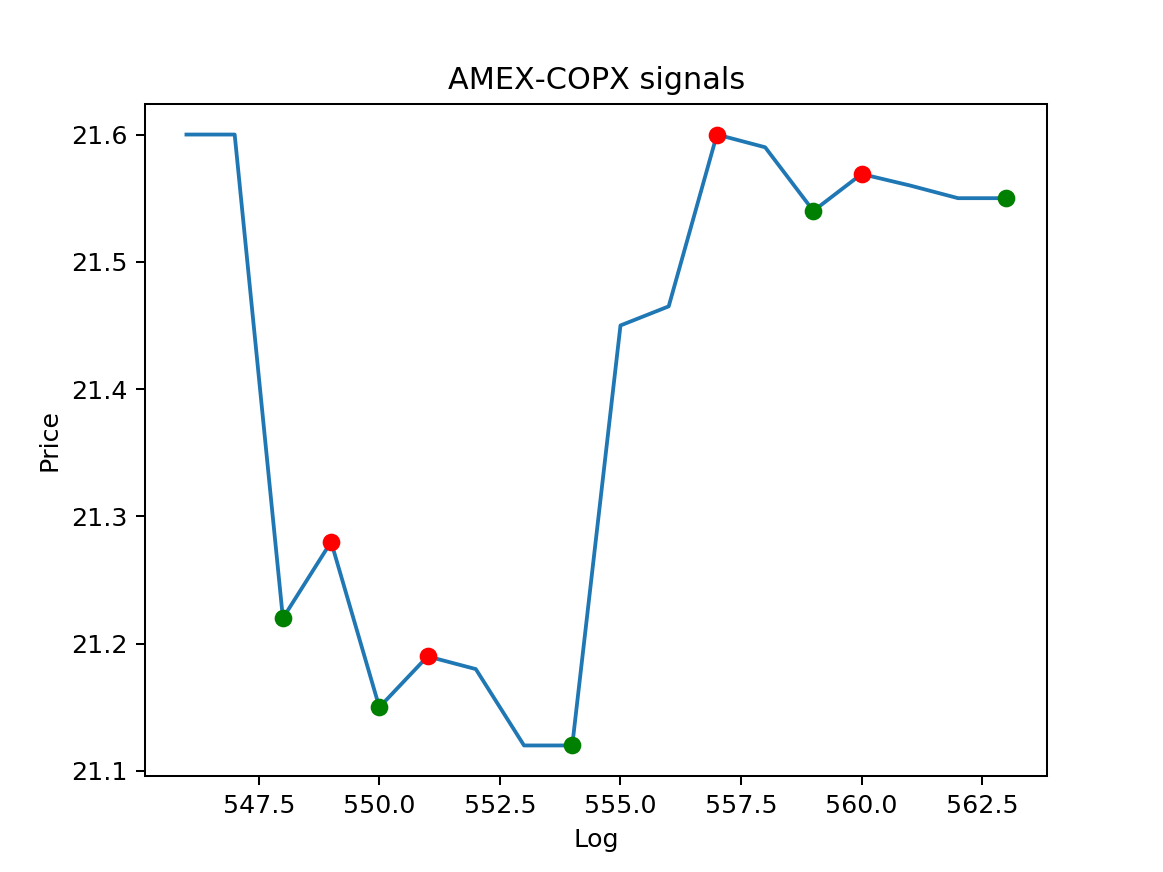

<IPython.core.display.Javascript object>


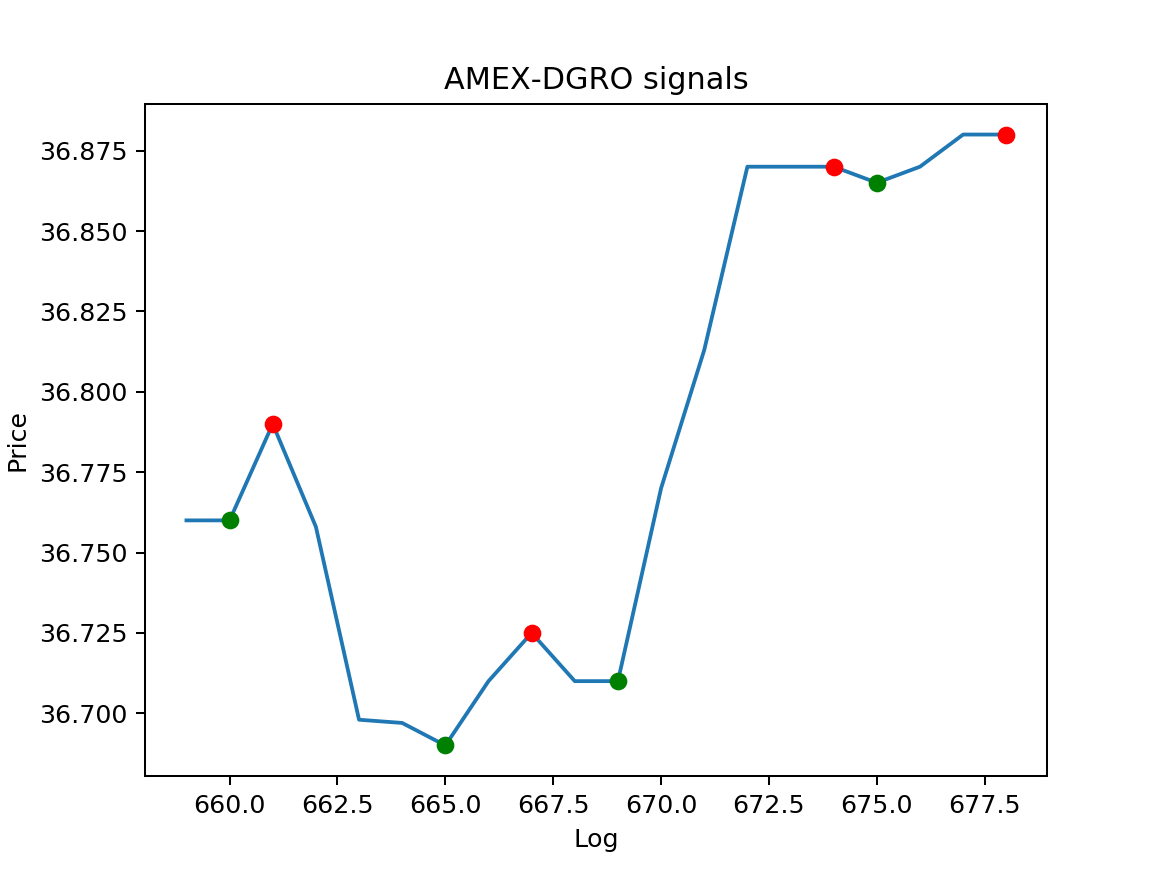

<IPython.core.display.Javascript object>


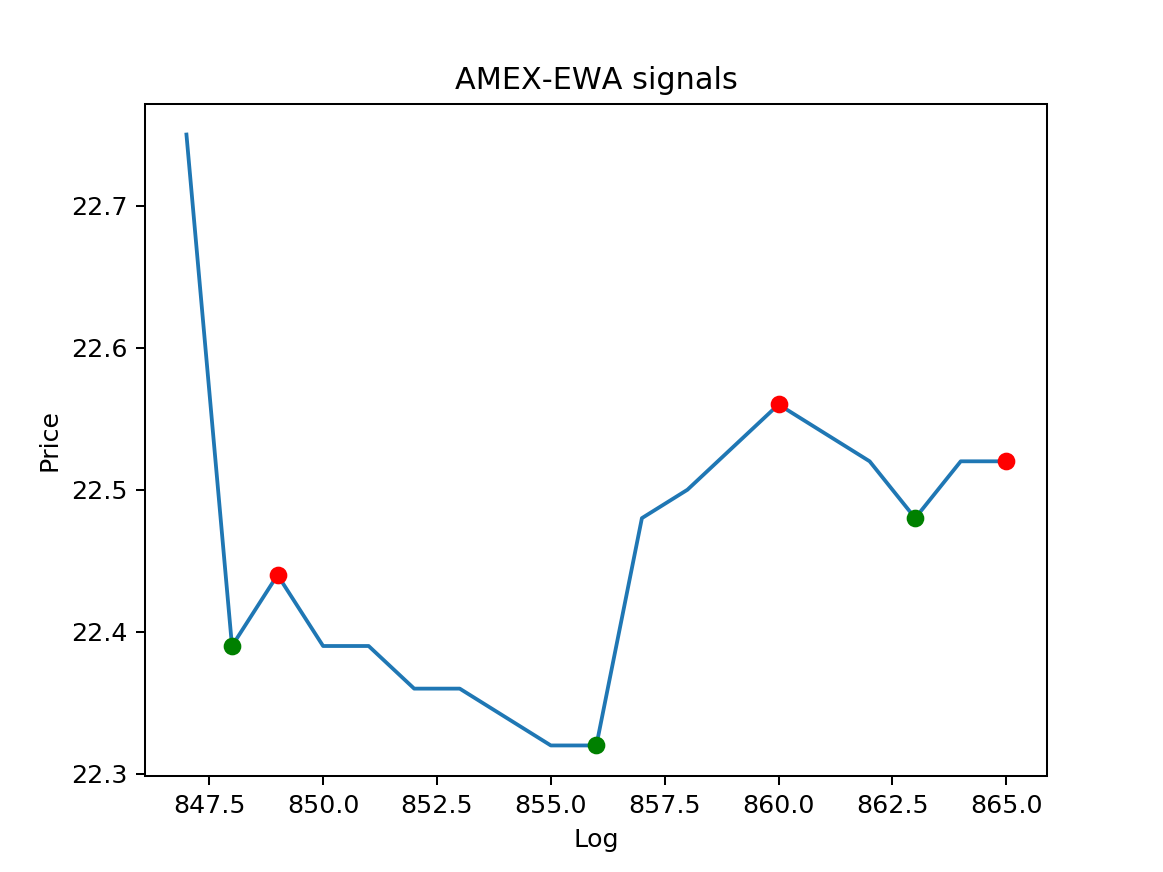

<IPython.core.display.Javascript object>


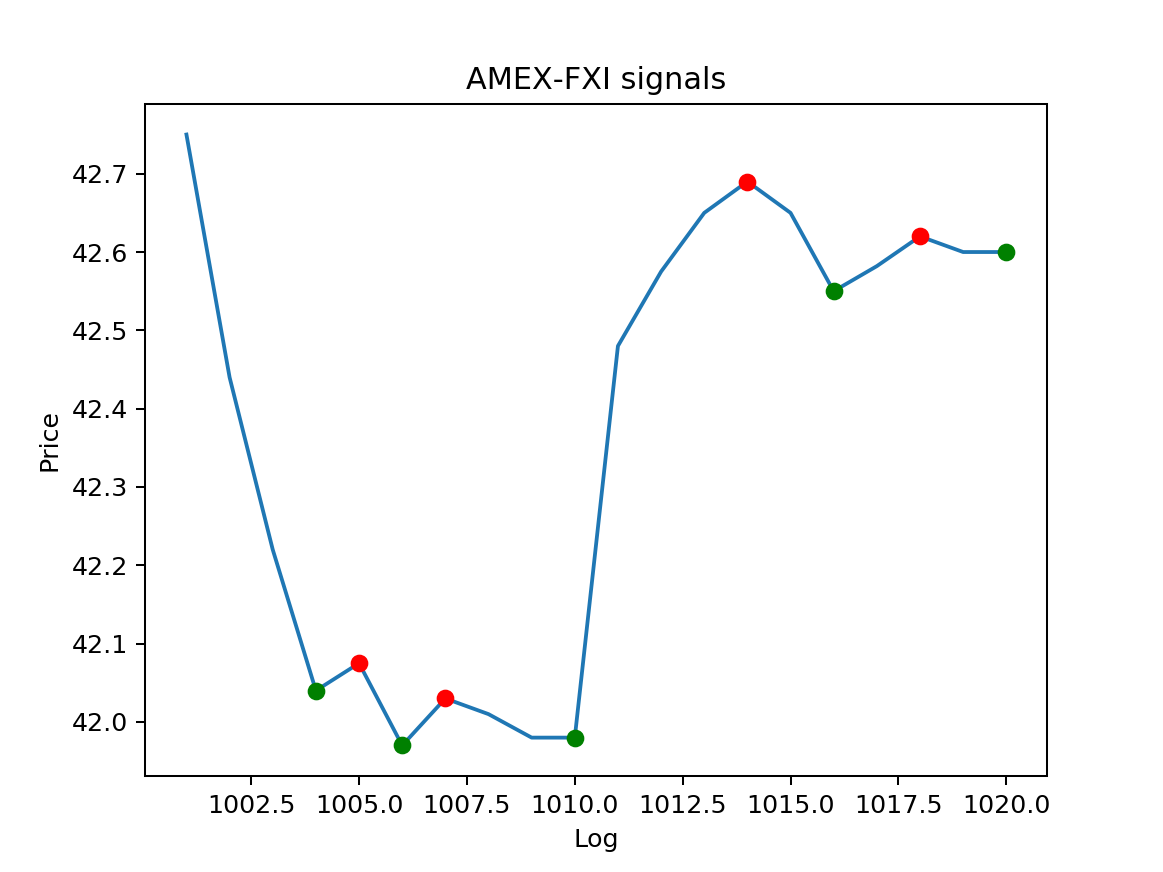

<IPython.core.display.Javascript object>


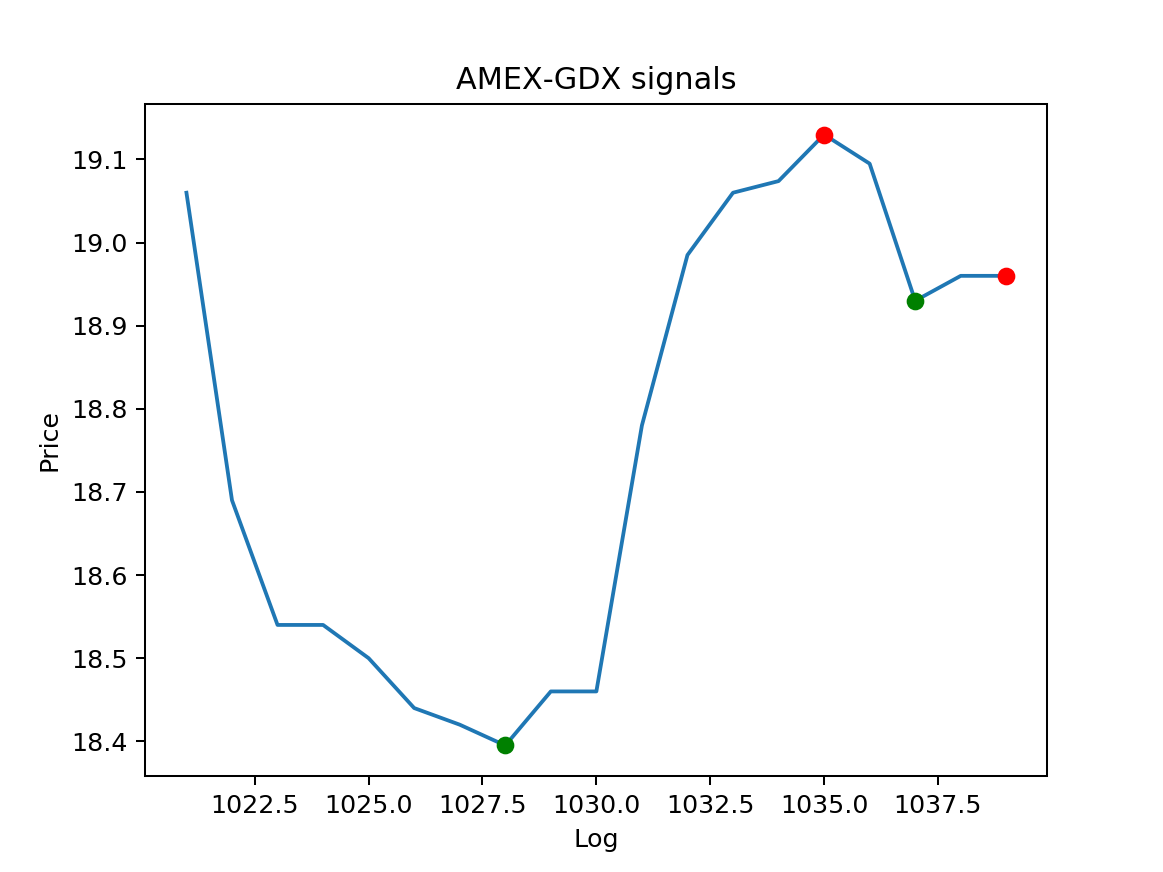

<IPython.core.display.Javascript object>


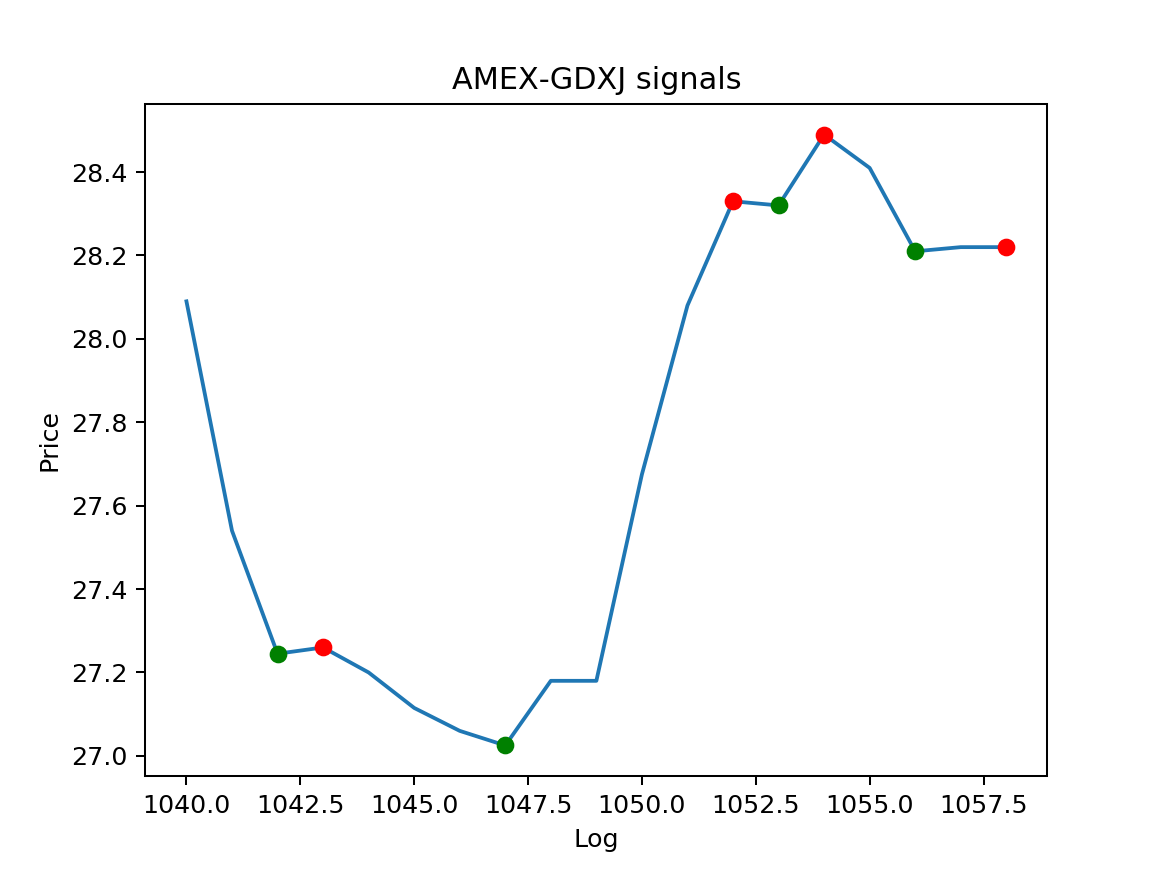

<IPython.core.display.Javascript object>


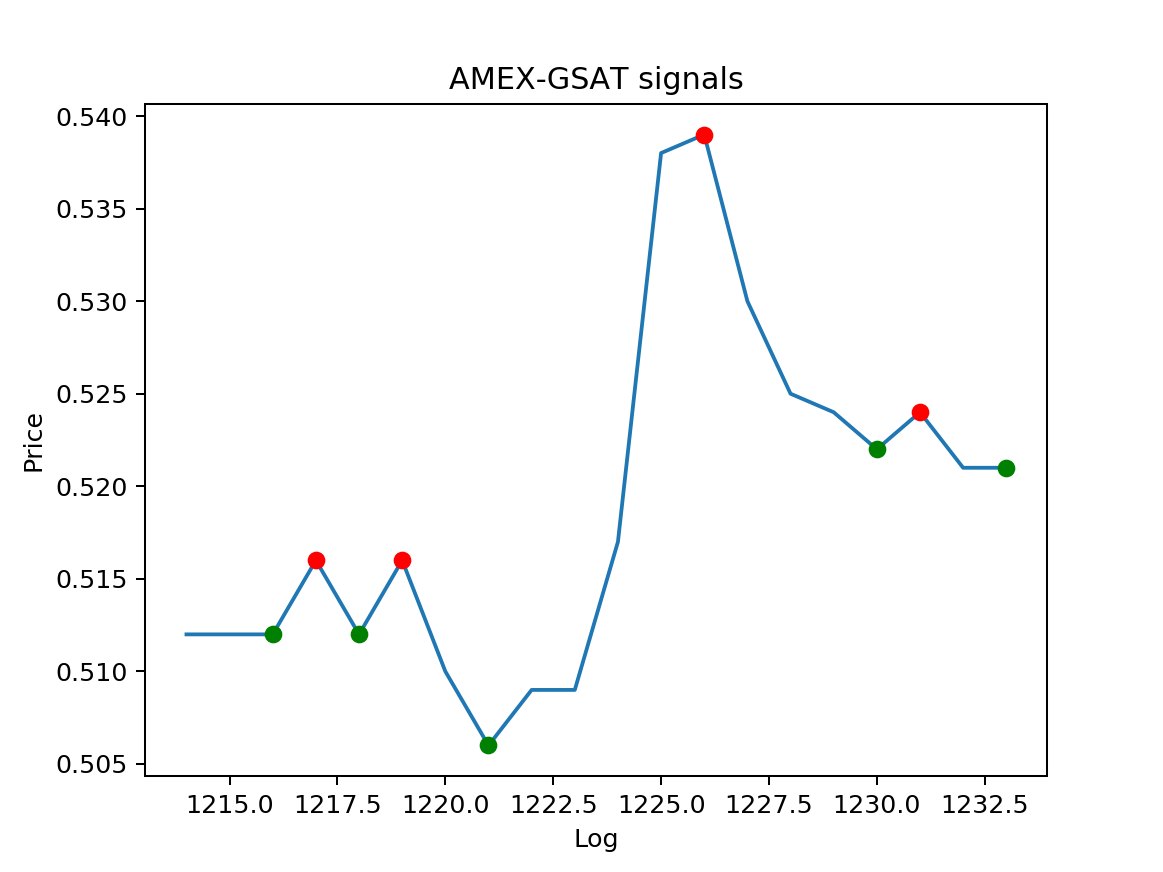

<IPython.core.display.Javascript object>


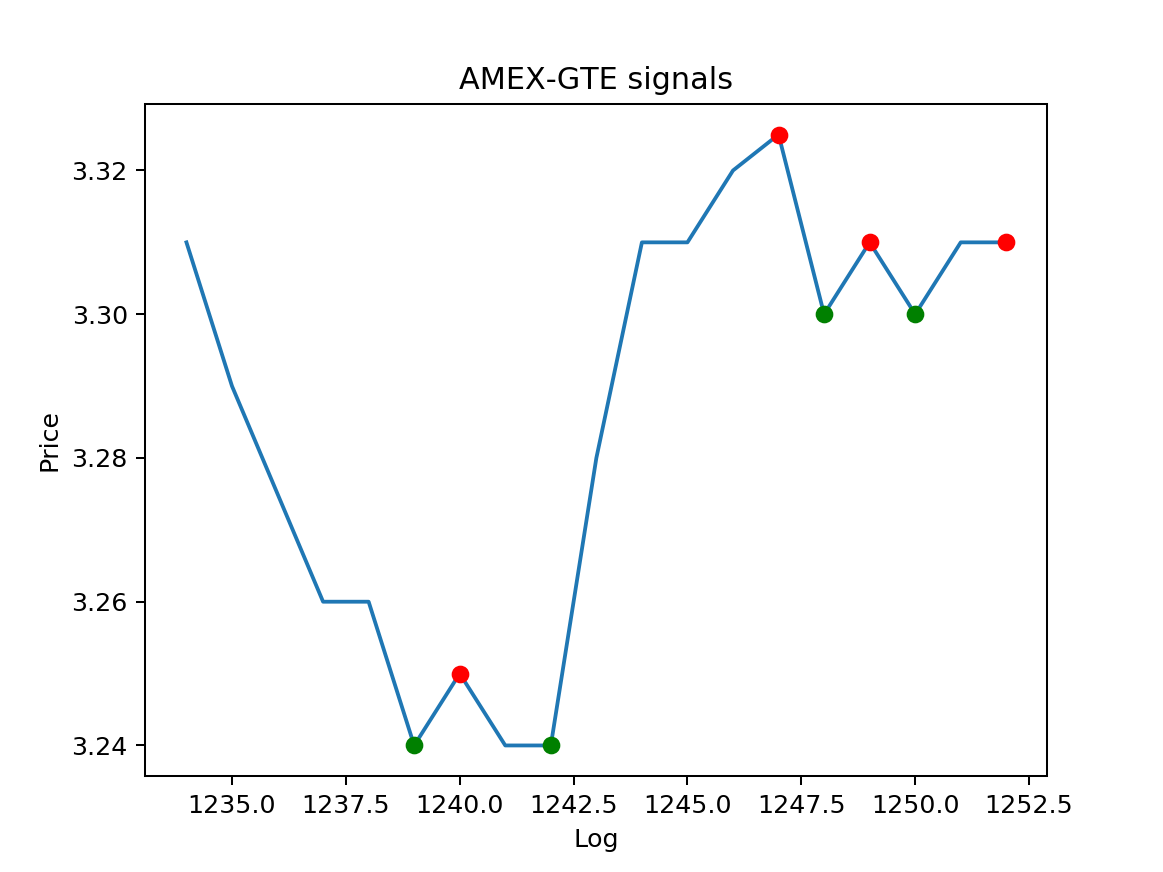

<IPython.core.display.Javascript object>


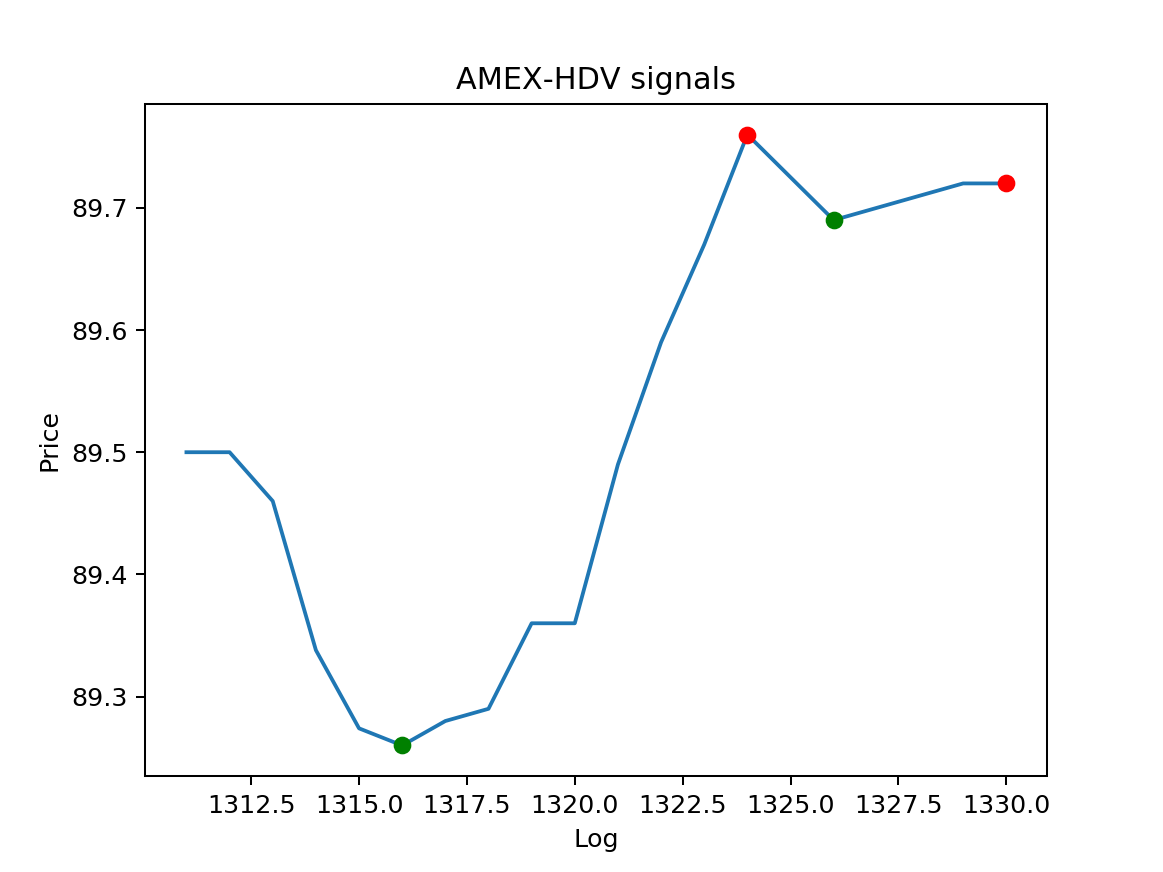

<IPython.core.display.Javascript object>


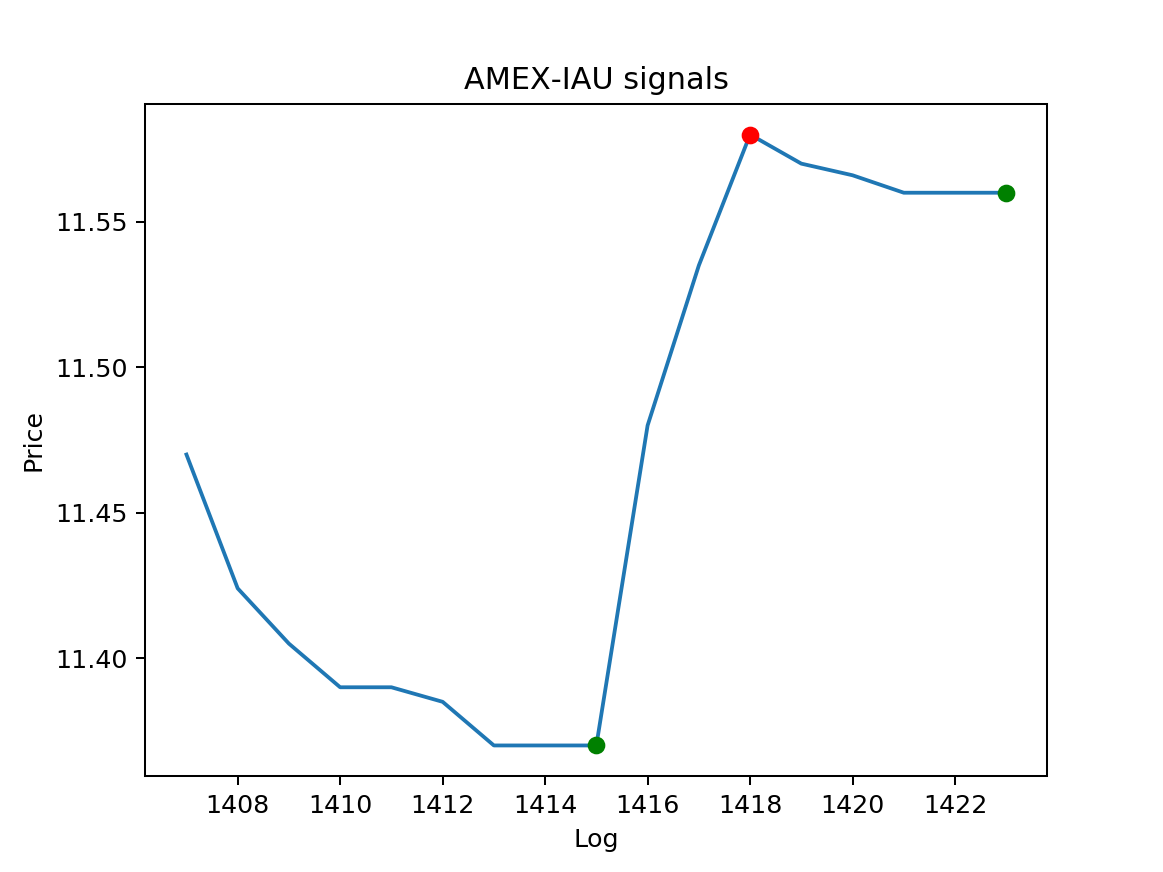

In [449]:
# one time visual check (might crash the machine)

%matplotlib notebook

unique_tickers = df_labeled.ticker.unique()
num=10
for t in unique_tickers:
    if (num>20) | (num < 10):
        continue
    num += 1

    df_test_t = df_labeled[df_labeled.ticker == t]

    plt.figure(num)
    plt.title(t+' signals')
    plt.xlabel('Log')
    plt.ylabel('Price')
    plt.plot(df_test_t.price)
    plt.plot(df_test_t[df_test_t.action=="sell"].price, 'ro', label='sell')
    plt.plot(df_test_t[df_test_t.action=="buy"].price, 'go', label='buy')
    plt.show()